# Distopia master class 

## Why distances
Distances are very important in the MDAnalysis ecosystem. Most analysis are underpinned by some kind of $R^3$ distance computation. e.g RSMD, RSMF etc etc. Even other "low" level math functions use distances as a component. **This makes distances a key target for optimization** for better MDAnalysis performance.


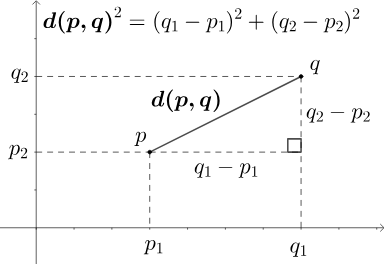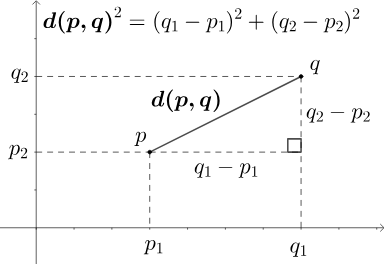



# Euclidean Distance and the Minimum Image Convention

In molecular simulations, the distance between two particles is a fundamental quantity used to compute interparticle forces and potential energies.
For two particles located at positions $\mathbf{r}_i$ and $\mathbf{r}_j$ in three-dimensional space, the *Euclidean distance* between them is defined as:

$r_{ij} = \left| \mathbf{r}_j - \mathbf{r}_i \right|
= \sqrt{(x_j - x_i)^2 + (y_j - y_i)^2 + (z_j - z_i)^2} $

However, when a simulation employs *periodic boundary conditions* (PBC), the simulation box is conceptually replicated infinitely in all spatial directions.
This means that each particle has infinitely many periodic images, and care must be taken to compute distances in a way that reflects the physically relevant (shortest) separation between particles.

---

## Periodic Boundary Conditions

Under PBC, if a particle moves outside one face of the simulation box, it re-enters from the opposite face.
Let the simulation box have dimensions $L_x$, $L_y$, and $L_z$.
When computing the distance between particles $i$ and $j$, we must account for the fact that the true minimum separation might involve one of the periodic images of particle $j$.

---

![title](./PBC.png)


## Minimum Image Convention

The *minimum image convention* (MIC) ensures that each particle interacts only with the **nearest periodic image** of every other particle.
This is achieved by mapping the displacement vector $\mathbf{r}_j - \mathbf{r}_i$ into the primary simulation box:

$\mathbf{r}_{ij} = \mathbf{r}_j - \mathbf{r}_i * \mathbf{L} \cdot \text{nint}\left( \frac{\mathbf{r}_j - \mathbf{r}_i}{\mathbf{L}} \right)$

where $\mathbf{L} = (L_x, L_y, L_z)$ represents the box dimensions and $\text{nint}(x)$ is the *nearest integer function*, which ensures the displacement lies within
$[-L_\alpha/2, L_\alpha/2]$ for each coordinate $\alpha \in {x, y, z}$.

The corresponding Euclidean distance under the minimum image convention is therefore:

$
r_{ij} = \left| \mathbf{r}*{ij} \right|
= \sqrt{r*{ij,x}^2 + r_{ij,y}^2 + r_{ij,z}^2}.
$

This guarantees that computed distances correspond to the physically nearest neighbors, avoiding overcounting interactions due to periodicity.

# How does MDAnalysis do distances?

Distances are done in the MDAnalysis distances library which exposes lots of powerful functionality by wrapping a C++ library

In [3]:
import MDAnalysis
from MDAnalysis.tests.datafiles import GRO, XTC, TRIC


u = MDAnalysis.Universe(GRO, XTC)
protein = u.select_atoms("protein")
water = u.select_atoms("water")


In [4]:
%%timeit 
distance_array = MDAnalysis.lib.distances.distance_array(protein, water,
                                            box=u.dimensions)

3.39 s ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note the use of box.dimensions**, passing in the PBCs to call the correct underlying function to calculate PBCs, under the hood this looks like the following

```python
    if box is not None:
        boxtype, box = check_box(box)
        if boxtype == "ortho":
            _run(
                "calc_distance_array_ortho",
                args=(reference, configuration, box, distances),
                backend=backend,
            )
        else:
            _run(
                "calc_distance_array_triclinic",
                args=(reference, configuration, box, distances),
                backend=backend,
            )
    else:
        _run(
            "calc_distance_array",
            args=(reference, configuration, distances),
            backend=backend,
        )
```


Here we are calling a fast C++ library written by MDAnalysis and compiled and linked in-situ. 

**lets go  deeper**



# Quick revision on crystal systems

from https://aflow.org/p/index.html

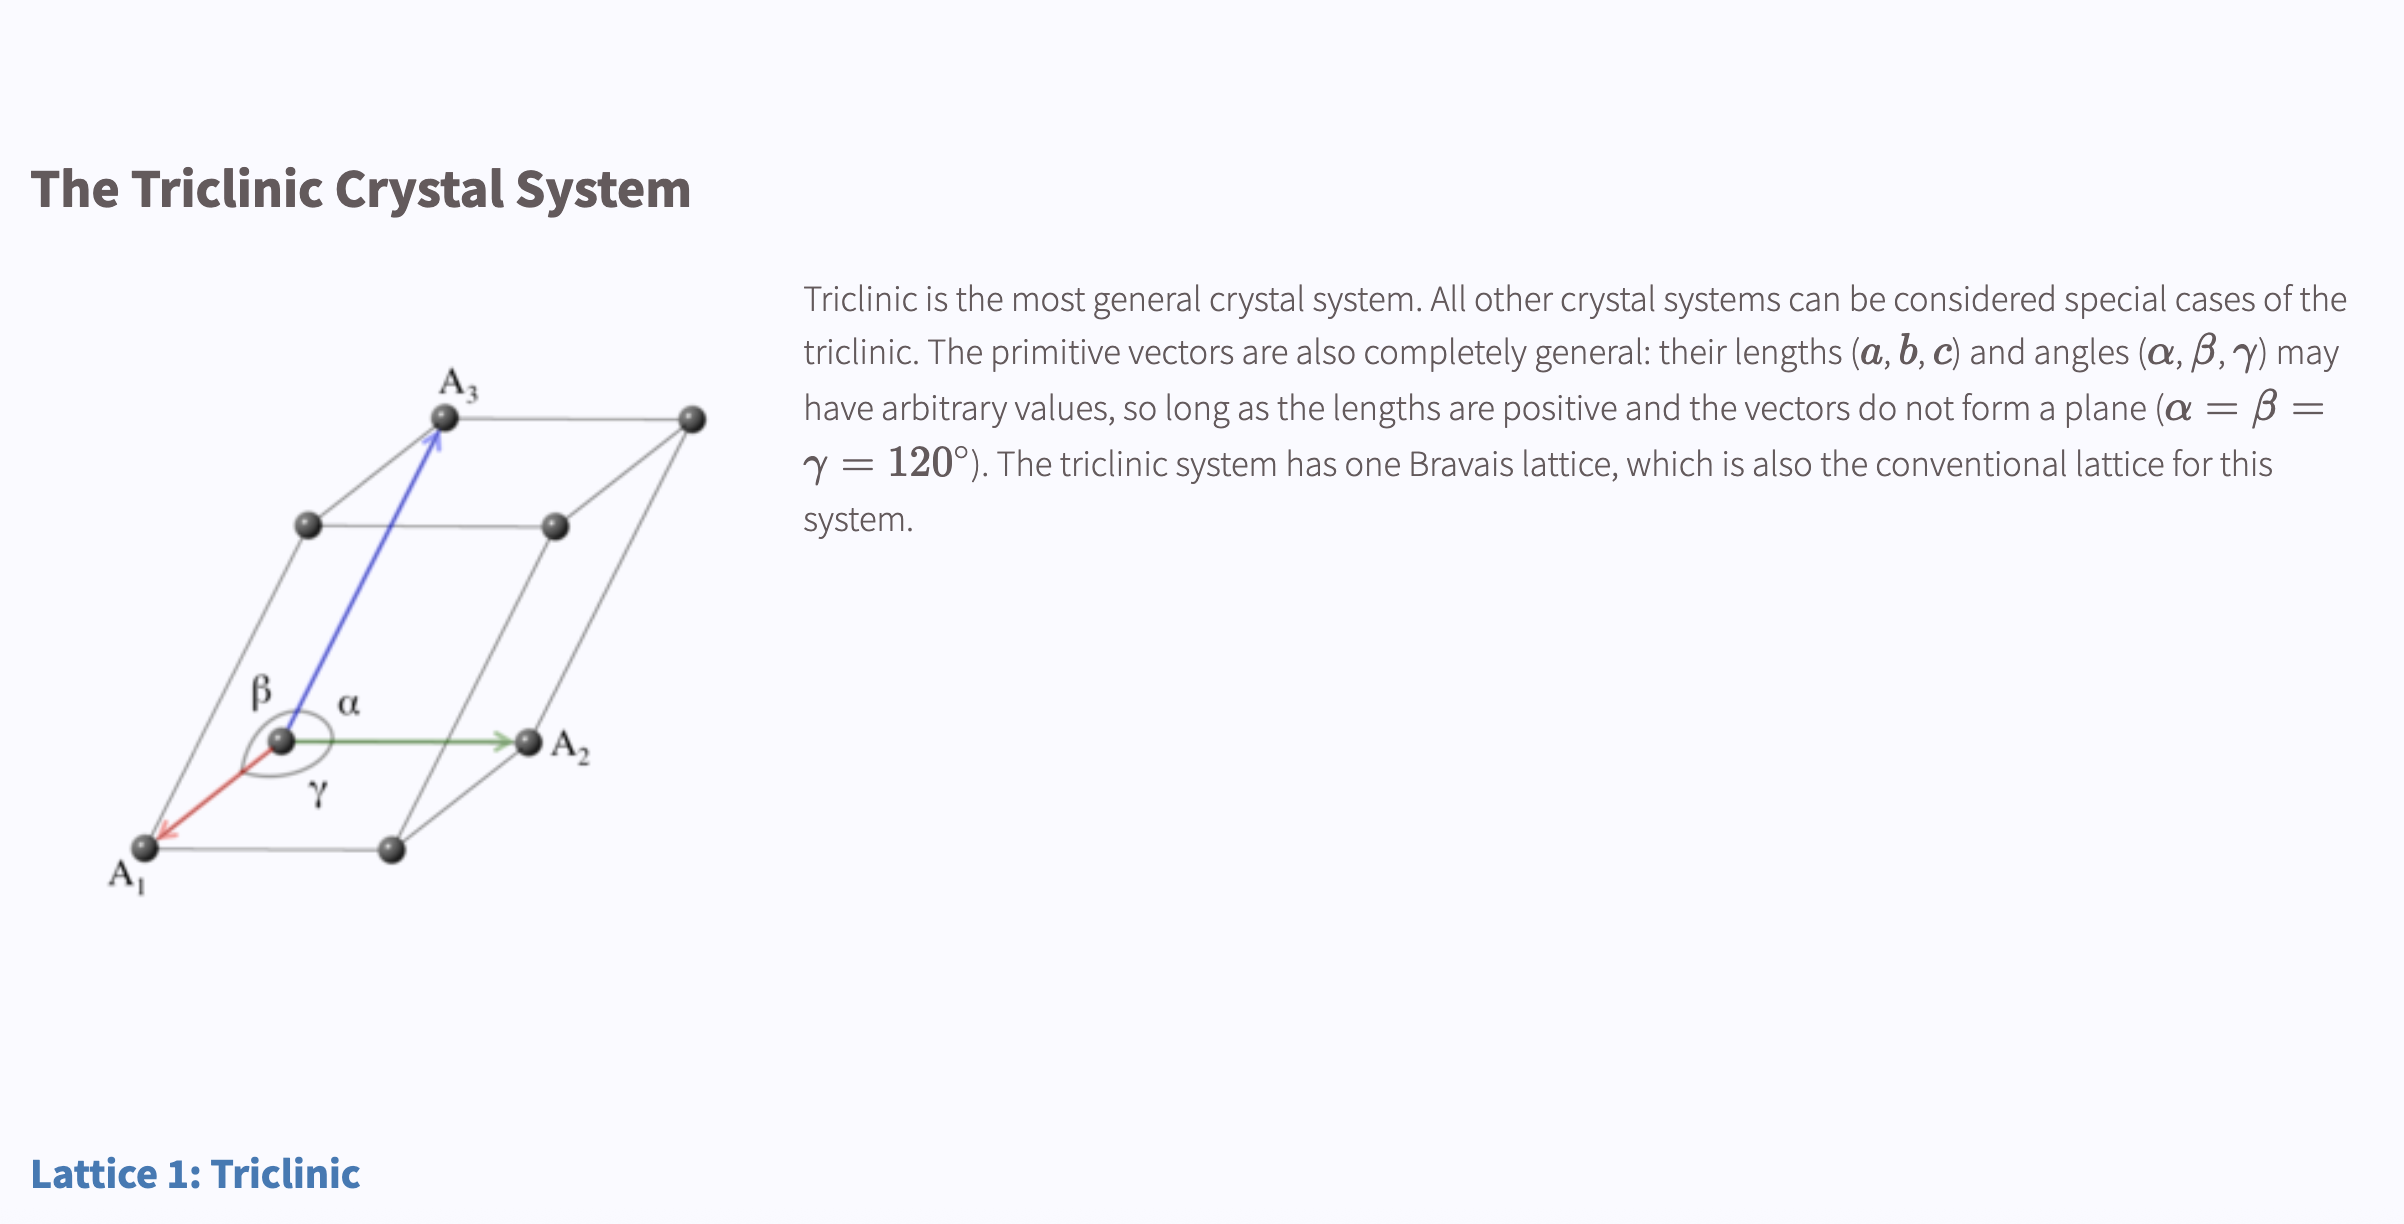
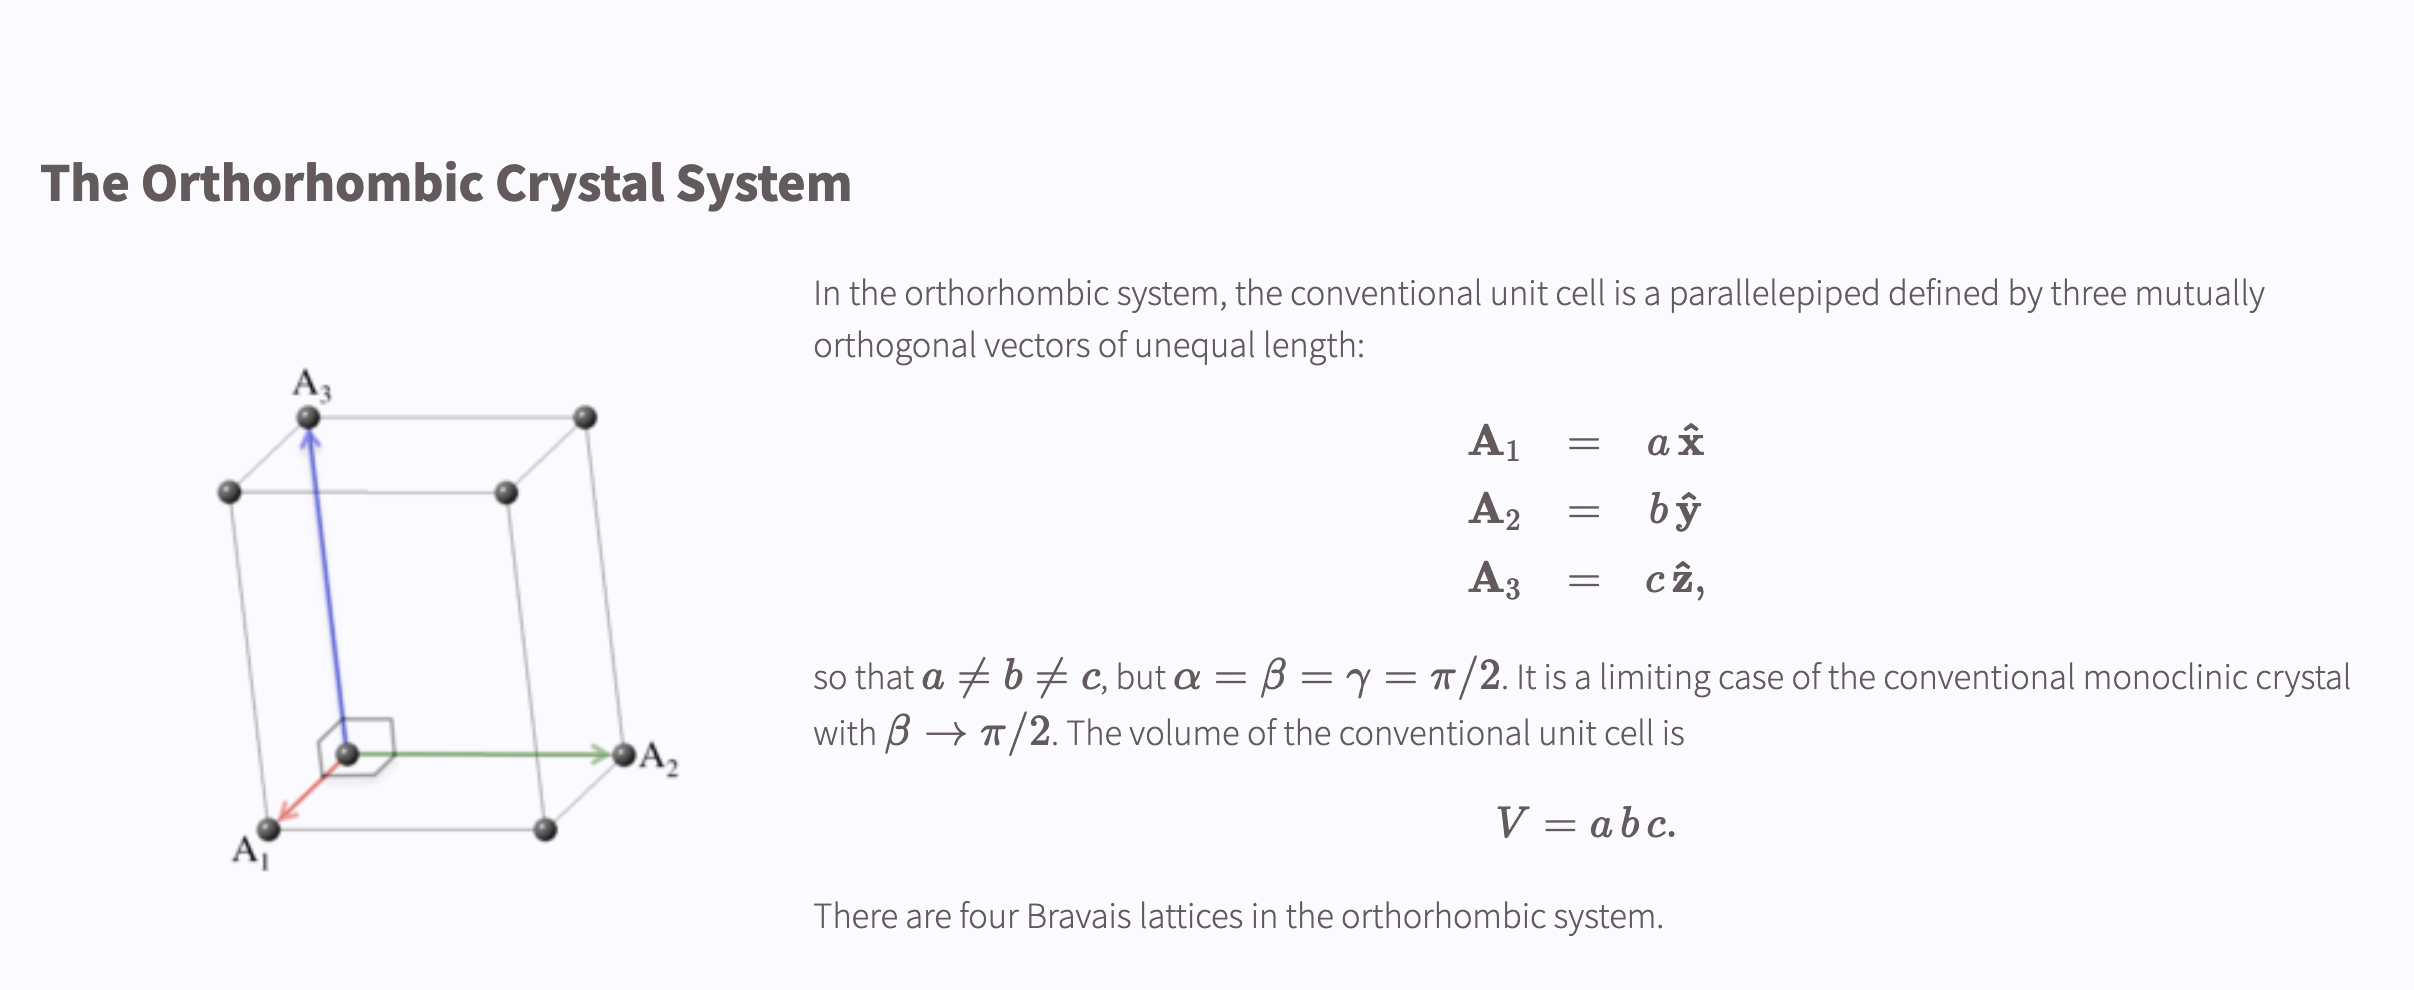

## OK so how do we do PBCs quickly in these lattices 

For orthorhombic lattices we can just map it into whichever box is closest

```c++
void minimum_image(double* x, float* box, float* inverse_box)
{
  int i;
  double s;
  for (i=0; i<3; i++) {
    if (box[i] > FLT_EPSILON) {
      s = inverse_box[i] * x[i];
      x[i] = box[i] * (s - round(s));
    }
  }
}
```

For triclinic lattices its much more involved and we need to check all 27 boxes around the primary box

```c++
void minimum_image_triclinic(double* dx, float* box)
{
   /*
    * Minimum image convention for triclinic systems, modelled after domain.cpp
    * in LAMMPS.
    * Assumes that there is a maximum separation of 1 box length (enforced in
    * dist functions by moving all particles to inside the box before
    * calculating separations).
    * Assumes box having zero values for box[1], box[2] and box[5]:
    *   /  a_x   0    0   \                 /  0    1    2  \
    *   |  b_x  b_y   0   |       indices:  |  3    4    5  |
    *   \  c_x  c_y  c_z  /                 \  6    7    8  /
    */
    double dx_min[3] = {0.0, 0.0, 0.0};
    double dsq_min = FLT_MAX;
    double dsq;
    double rx;
    double ry[2];
    double rz[3];
    int ix, iy, iz;
    for (ix = -1; ix < 2; ++ix) {
        rx = dx[0] + box[0] * ix;
        for (iy = -1; iy < 2; ++iy) {
            ry[0] = rx + box[3] * iy;
            ry[1] = dx[1] + box[4] * iy;
            for (iz = -1; iz < 2; ++iz) {
                rz[0] = ry[0] + box[6] * iz;
                rz[1] = ry[1] + box[7] * iz;
                rz[2] = dx[2] + box[8] * iz;
                dsq = rz[0] * rz[0] + rz[1] * rz[1] + rz[2] * rz[2];
                if (dsq < dsq_min) {
                    dsq_min = dsq;
                    dx_min[0] = rz[0];
                    dx_min[1] = rz[1];
                    dx_min[2] = rz[2];
                }
            }
        }
    }
    dx[0] = dx_min[0];
    dx[1] = dx_min[1];
    dx[2] = dx_min[2];
}
```

# How to make C / C++ faster


We can make C / C++ a lot faster by using SIMD registers in our CPU. SIMD are special registers that allow you to process 




## Compare the following two paradigms for multiplying 8  bit `ints`
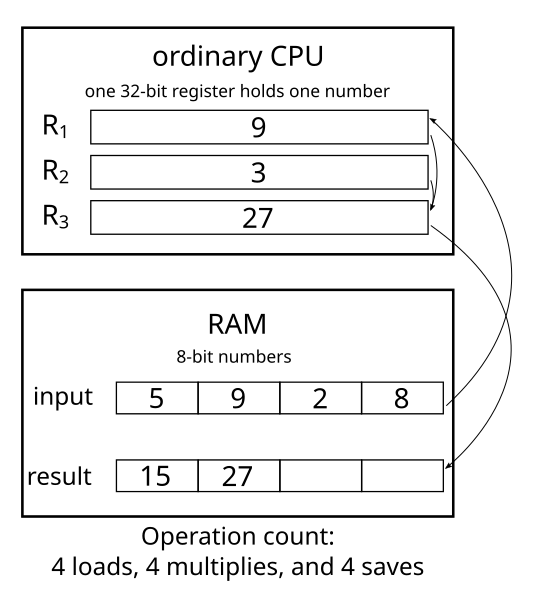


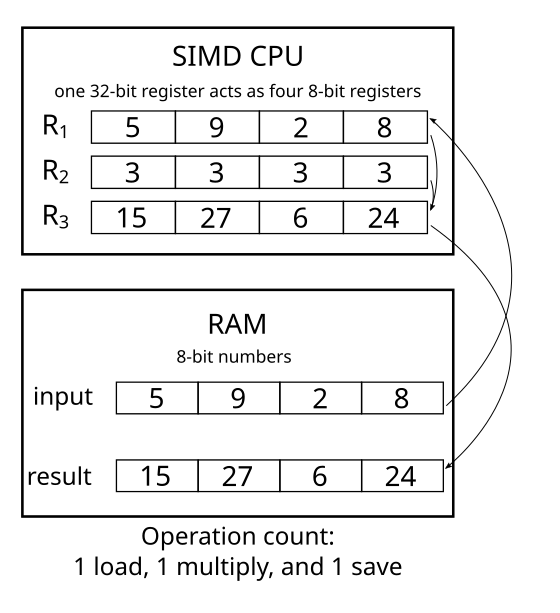


## SIMD is a feature of your CPU
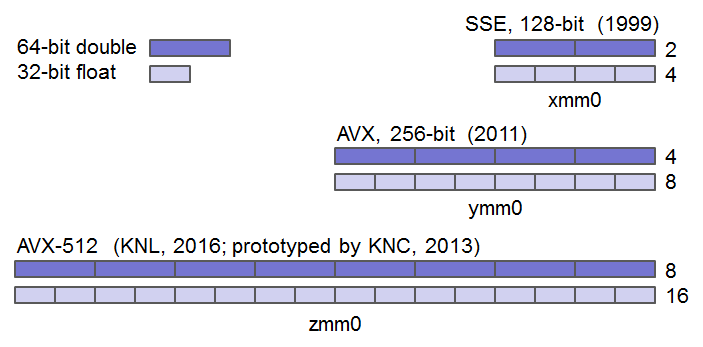


# Optimization, Auto-Vec and SIMD



Your compiler can apply some normal high-performance compilation **compatible with any CPU**.

```bash
g++ my_program.cpp -o my_program -O3  -flto -DNDEBUG
```

You can also tell it to go even further by attempting to add SIMD optimization where possible

```bash
g++ my_program.cpp -o my_program -O3 -march=native -mtune=native -flto -DNDEBUG
```

More on this blog: https://lemire.me/blog/2018/07/25/it-is-more-complicated-than-i-thought-mtune-march-in-gcc/



The best way to visualise the results of this is on [Compiler Explorer](https://godbolt.org/)



# We can do even better 


The compiler is not all seeing and can't do large scale data transformations that would result in downstream changes to vectorization

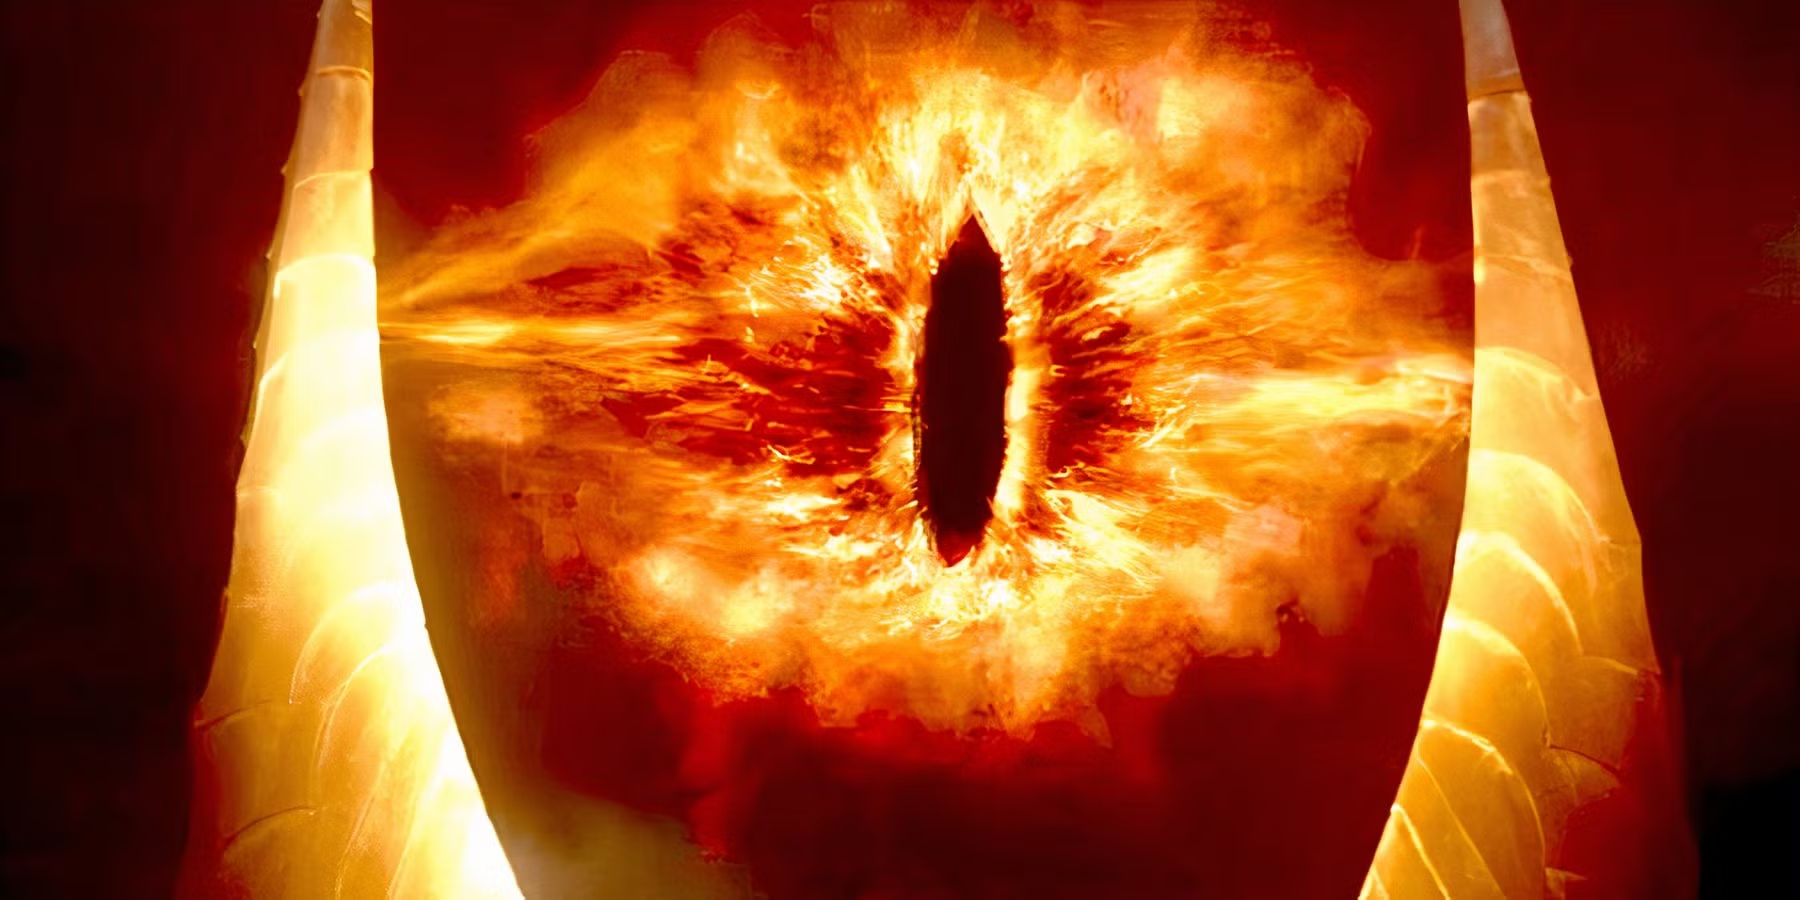

# There is a graded hierarchy of how deep you want to go into controlling SIMD

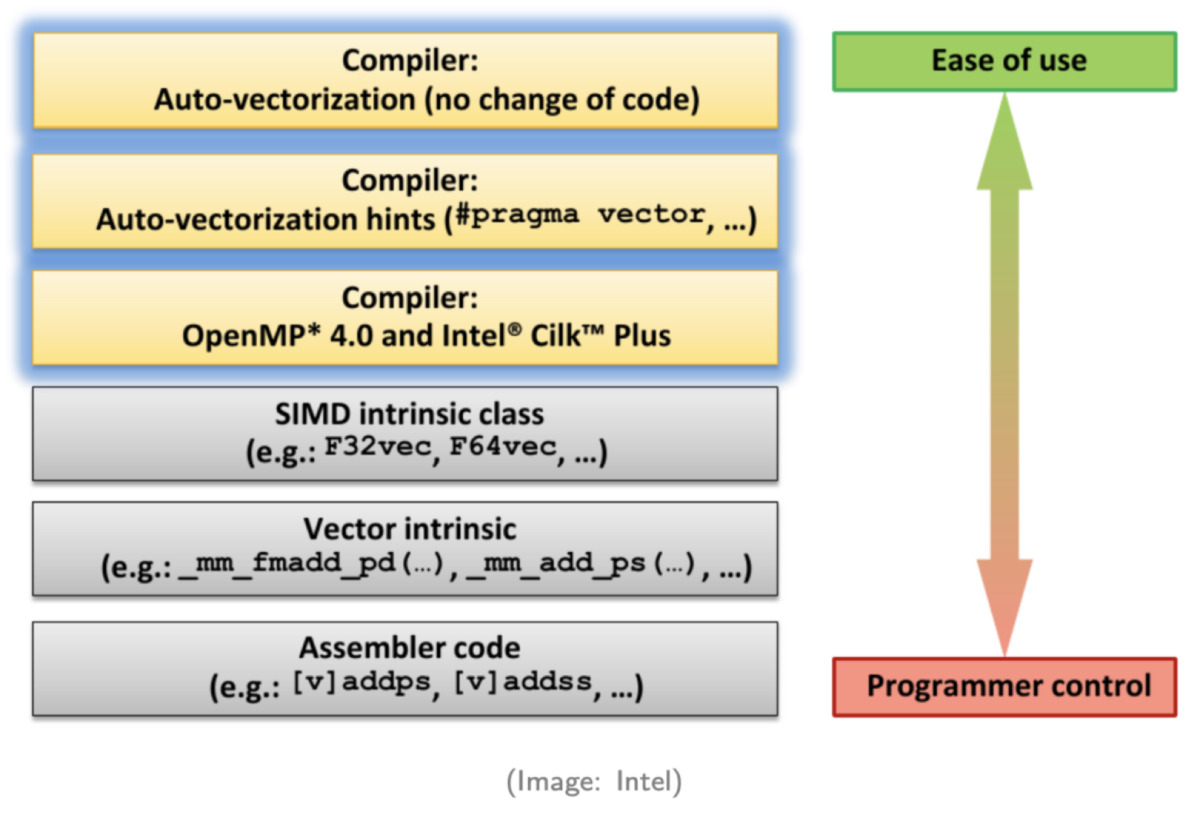

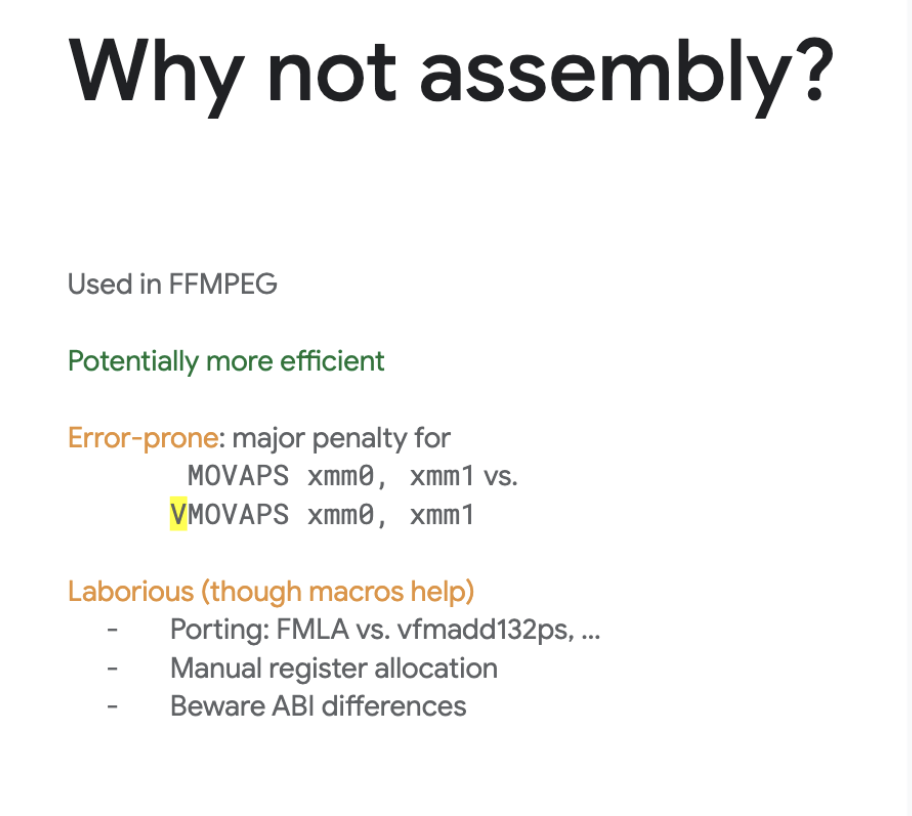

## Enter distopia 

Distopia is a fully hand-vectorised version of the MDAnalysis distance library, written using Google's Highway: https://github.com/google/highway

Highway handles the very complicated platform dependency code and works for all major CPUs. It also allows dynamic dispatch to multiple versions of the same function compiled for different architectures. 

https://github.com/google/highway/blob/master/g3doc/highway_intro.pdf



In [8]:
import distopia
import numpy as np 

N = 10000
box = 10
# make random coordinates that overhang the box
c0 = np.random.rand(N, 3).astype(np.float32)*2*box
c1 = np.random.rand(N, 3).astype(np.float32)*2*box
box = np.asarray([box, box, box], dtype=np.float32)

# pairwise distances orthorhombic box
distances = distopia.distances_ortho(c0, c1, box)


In [9]:

# full distance matrix 
distance_matrix = distopia.distance_array_ortho(c0, c1, box)



In [10]:
# pairwise angles in a general triclinc box just for fun
c2 = np.random.rand(N, 3).astype(np.float32)*2*box
triclinic_box = np.asarray([[10, 0, 0], [1, 10, 0], [1, 0, 10]], dtype=np.float32)

angles = distopia.angles_triclinic(c0, c1, c2, triclinic_box)

In [13]:
# pairwise dihedrals in a general triclinc box just for fun
c3 = np.random.rand(N, 3).astype(np.float32)*2*box
triclinic_box = np.asarray([[10, 0, 0], [1, 10, 0], [1, 0, 10]], dtype=np.float32)

angles = distopia.dihedrals_triclinic(c0, c1, c2, c3, triclinic_box)

# How fast is it?

Distopia is up to 10x faster than the MDAnalysis C++ backend 


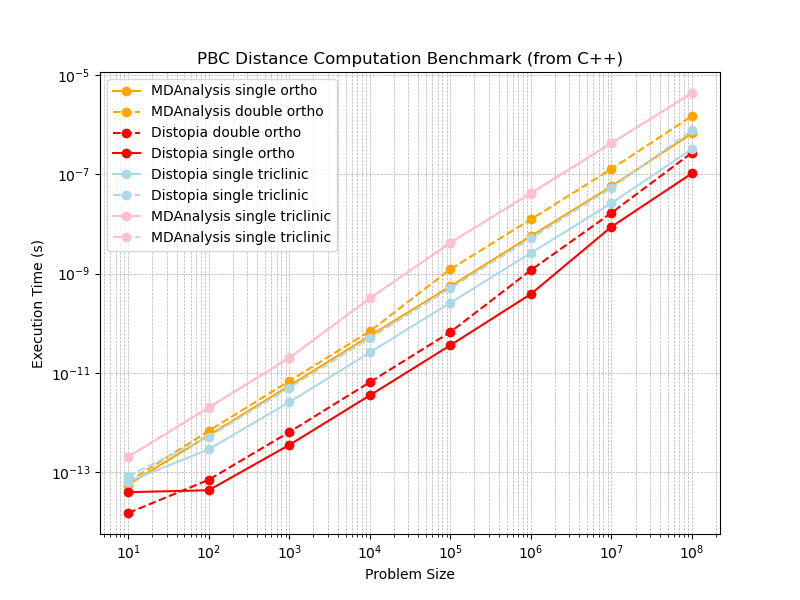

Distopia is blazingly fast for small problems  >> GPU


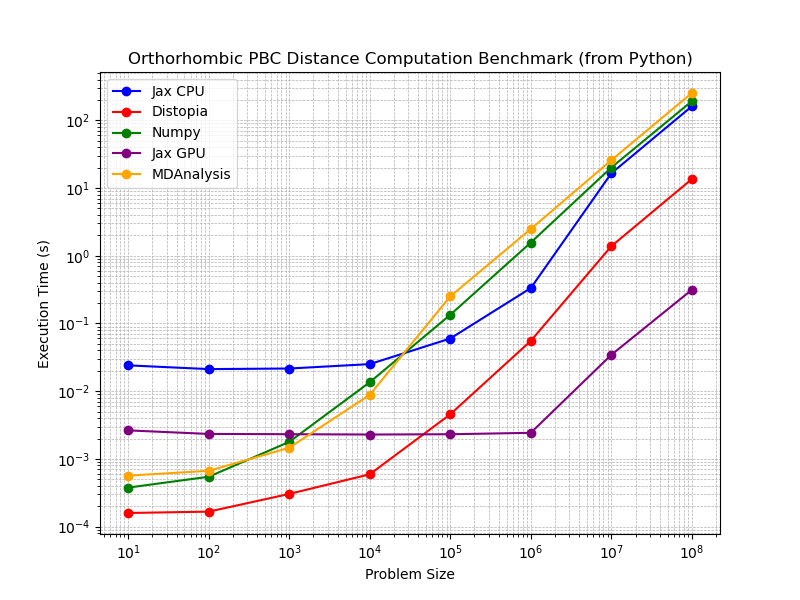

Once over about 10k distances JAX based GPU autovec starts to dominate (hand written CUDA not tested). 

**Distopia is extremely cost efficent if using cloud compute resources**




# What about in MDAnalysis!

Its easy to use distopia in MDAnalysis! Its compatible with Mac and Linux (compiler bug in MSVC :( )

In [5]:
u = MDAnalysis.Universe(GRO, XTC)
protein = u.select_atoms("protein")
water = u.select_atoms("water")


In [6]:
%%timeit 
distance_array = MDAnalysis.lib.distances.distance_array(protein, water,
                                            box=u.dimensions, backend="distopia")

2.66 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
